## Introduction

This code will be used to acquire data and visualize it

##### Data Acquisition and Extraction

In [33]:
import os
import urllib.request
import tarfile

url = "https://cbioportal-datahub.s3.amazonaws.com/brca_metabric.tar.gz"
archive_path = "../data/brca_metabric.tar.gz"

os.makedirs("../artifacts/images", exist_ok=True)


if not (os.path.exists("../data")):
  os.mkdir("../data")
  print("Data directory created")

if not (os.path.exists("../artifacts")):
  os.mkdir("../artifacts")
  print("Artifact directory created")

if (os.path.exists(archive_path)):
  print("Data already downloaded")
else:
  print("Downloading Data")
  urllib.request.urlretrieve(url, archive_path)
  print("Download Complete")

if not (os.path.exists("../data/brca_metabric")):
  with tarfile.open(archive_path, "r") as tar:
    print("Extracting archive")
    tar.extractall(path="../data/")
    print("Extraction complete")
else:
  print("Data already extracted")


Data already downloaded
Data already extracted


##### Imports for Data Framing and Plotting

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

##### Data Framing

In [91]:
metabric_dir = "../data/brca_metabric"
data_path = f"{metabric_dir}/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt"
metadata_path = f"{metabric_dir}/data_clinical_patient.txt"

#Read gene expression data
expr_df = pd.read_csv(data_path, sep="\t")
#safe one version with Hugo_symbols
expr_with_Hugo_df = expr_df

expr_df = expr_df.set_index("Entrez_Gene_Id")

expr_df = expr_df.drop(columns=["Hugo_Symbol"])

expr_transposed_df = expr_df.T

meta_df = pd.read_csv(metadata_path, sep="\t", comment="#")
meta_df = meta_df.set_index("PATIENT_ID")

##### Creating one Dataframe with only PAM50 Genes

In [92]:
# only runs first time without Error, ignore Error if you run it a second time, you can still use PAM50_transposed_df in next python fields
expr_with_Hugo_df.set_index('Hugo_Symbol', inplace=True)
selected_symbols = [symbol for symbol in
                    ["ACTR3B", "ANLN", "BAG1", "BCL2", "BIRC5", "BLVRA", "CCNB1", "CCNE1", "CDC20", "CDC6", "CDH3",
                     "CENPF", "CEP55", "CXXC5", "EGFR", "ERBB2", "ESR1", "EXO1", "FGFR4", "FOXA1", "FOXC1", "GPR160",
                     "GRB7", "KIF2C", "KRT14", "KRT17", "KRT5", "MAPT", "MDM2", "MELK", "MIA", "MKI67", "MLPH", "MMP11",
                     "MYBL2", "MYC", "NAT1", "NDC80", "NUF2", "ORC6L", "PGR", "PHGDH", "PTTG1", "RRM2", "SFRP1",
                     "SLC39A6", "TMEM45B", "TYMS", "UBE2C", "UBE2T"] if symbol in expr_with_Hugo_df.index]
PAM50_df = expr_with_Hugo_df.loc[selected_symbols]
PAM50_df = PAM50_df.set_index("Entrez_Gene_Id")
PAM50_transposed_df = PAM50_df.T

print("Dataframe created")

Dataframe created


## Metadata Plots with Input Data before Cleaning

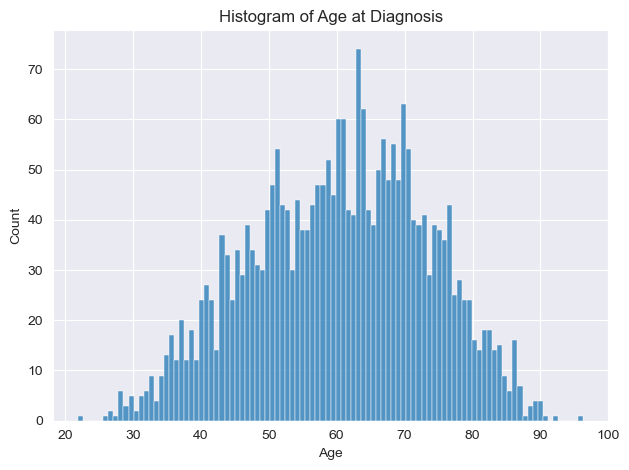

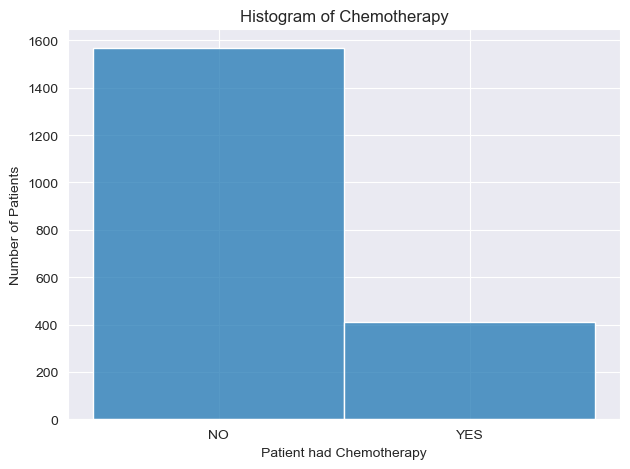

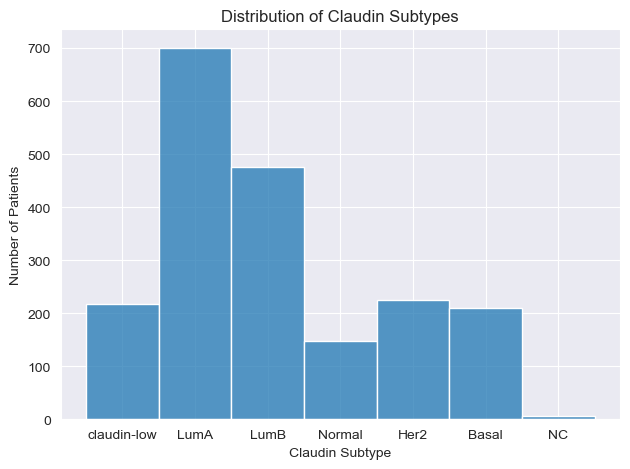

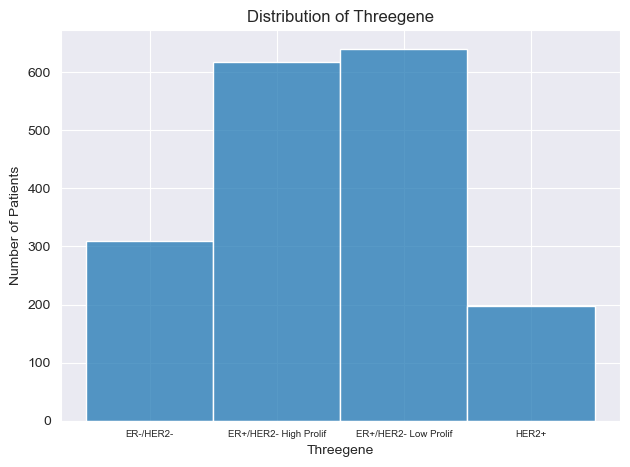

In [44]:
#eval: false

#Age at Point of Diagnosis distribution

plt.figure()
sns.histplot(meta_df["AGE_AT_DIAGNOSIS"], bins=100)
plt.title("Histogram of Age at Diagnosis")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../artifacts/images/AgePlot.png")
plt.show()
plt.close()

#Chemotherapy

plt.figure()
sns.histplot(meta_df["CHEMOTHERAPY"], bins=2)
plt.title("Histogram of Chemotherapy")
plt.xlabel("Patient had Chemotherapy")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.savefig("../artifacts/images/Chemotherapy.png")
plt.show()
plt.close()
#Distribution of Claudin-Subtypes
plt.figure()
sns.histplot(meta_df["CLAUDIN_SUBTYPE"], bins=7)
plt.title("Distribution of Claudin Subtypes")
plt.xlabel("Claudin Subtype")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.savefig("../artifacts/images/Claudine_Distribution.png")
plt.show()
plt.close()

#THREEGENE
#Distribution of Threegene

plt.figure()
sns.histplot(meta_df["THREEGENE"], bins=4)
plt.title("Distribution of Threegene")
plt.xlabel("Threegene")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.xticks(fontsize=7)
plt.savefig("../artifacts/images/ThreeGene_Distribution.png")
plt.show()
plt.close()

## Expression Data Plots before cleaning the Dataset

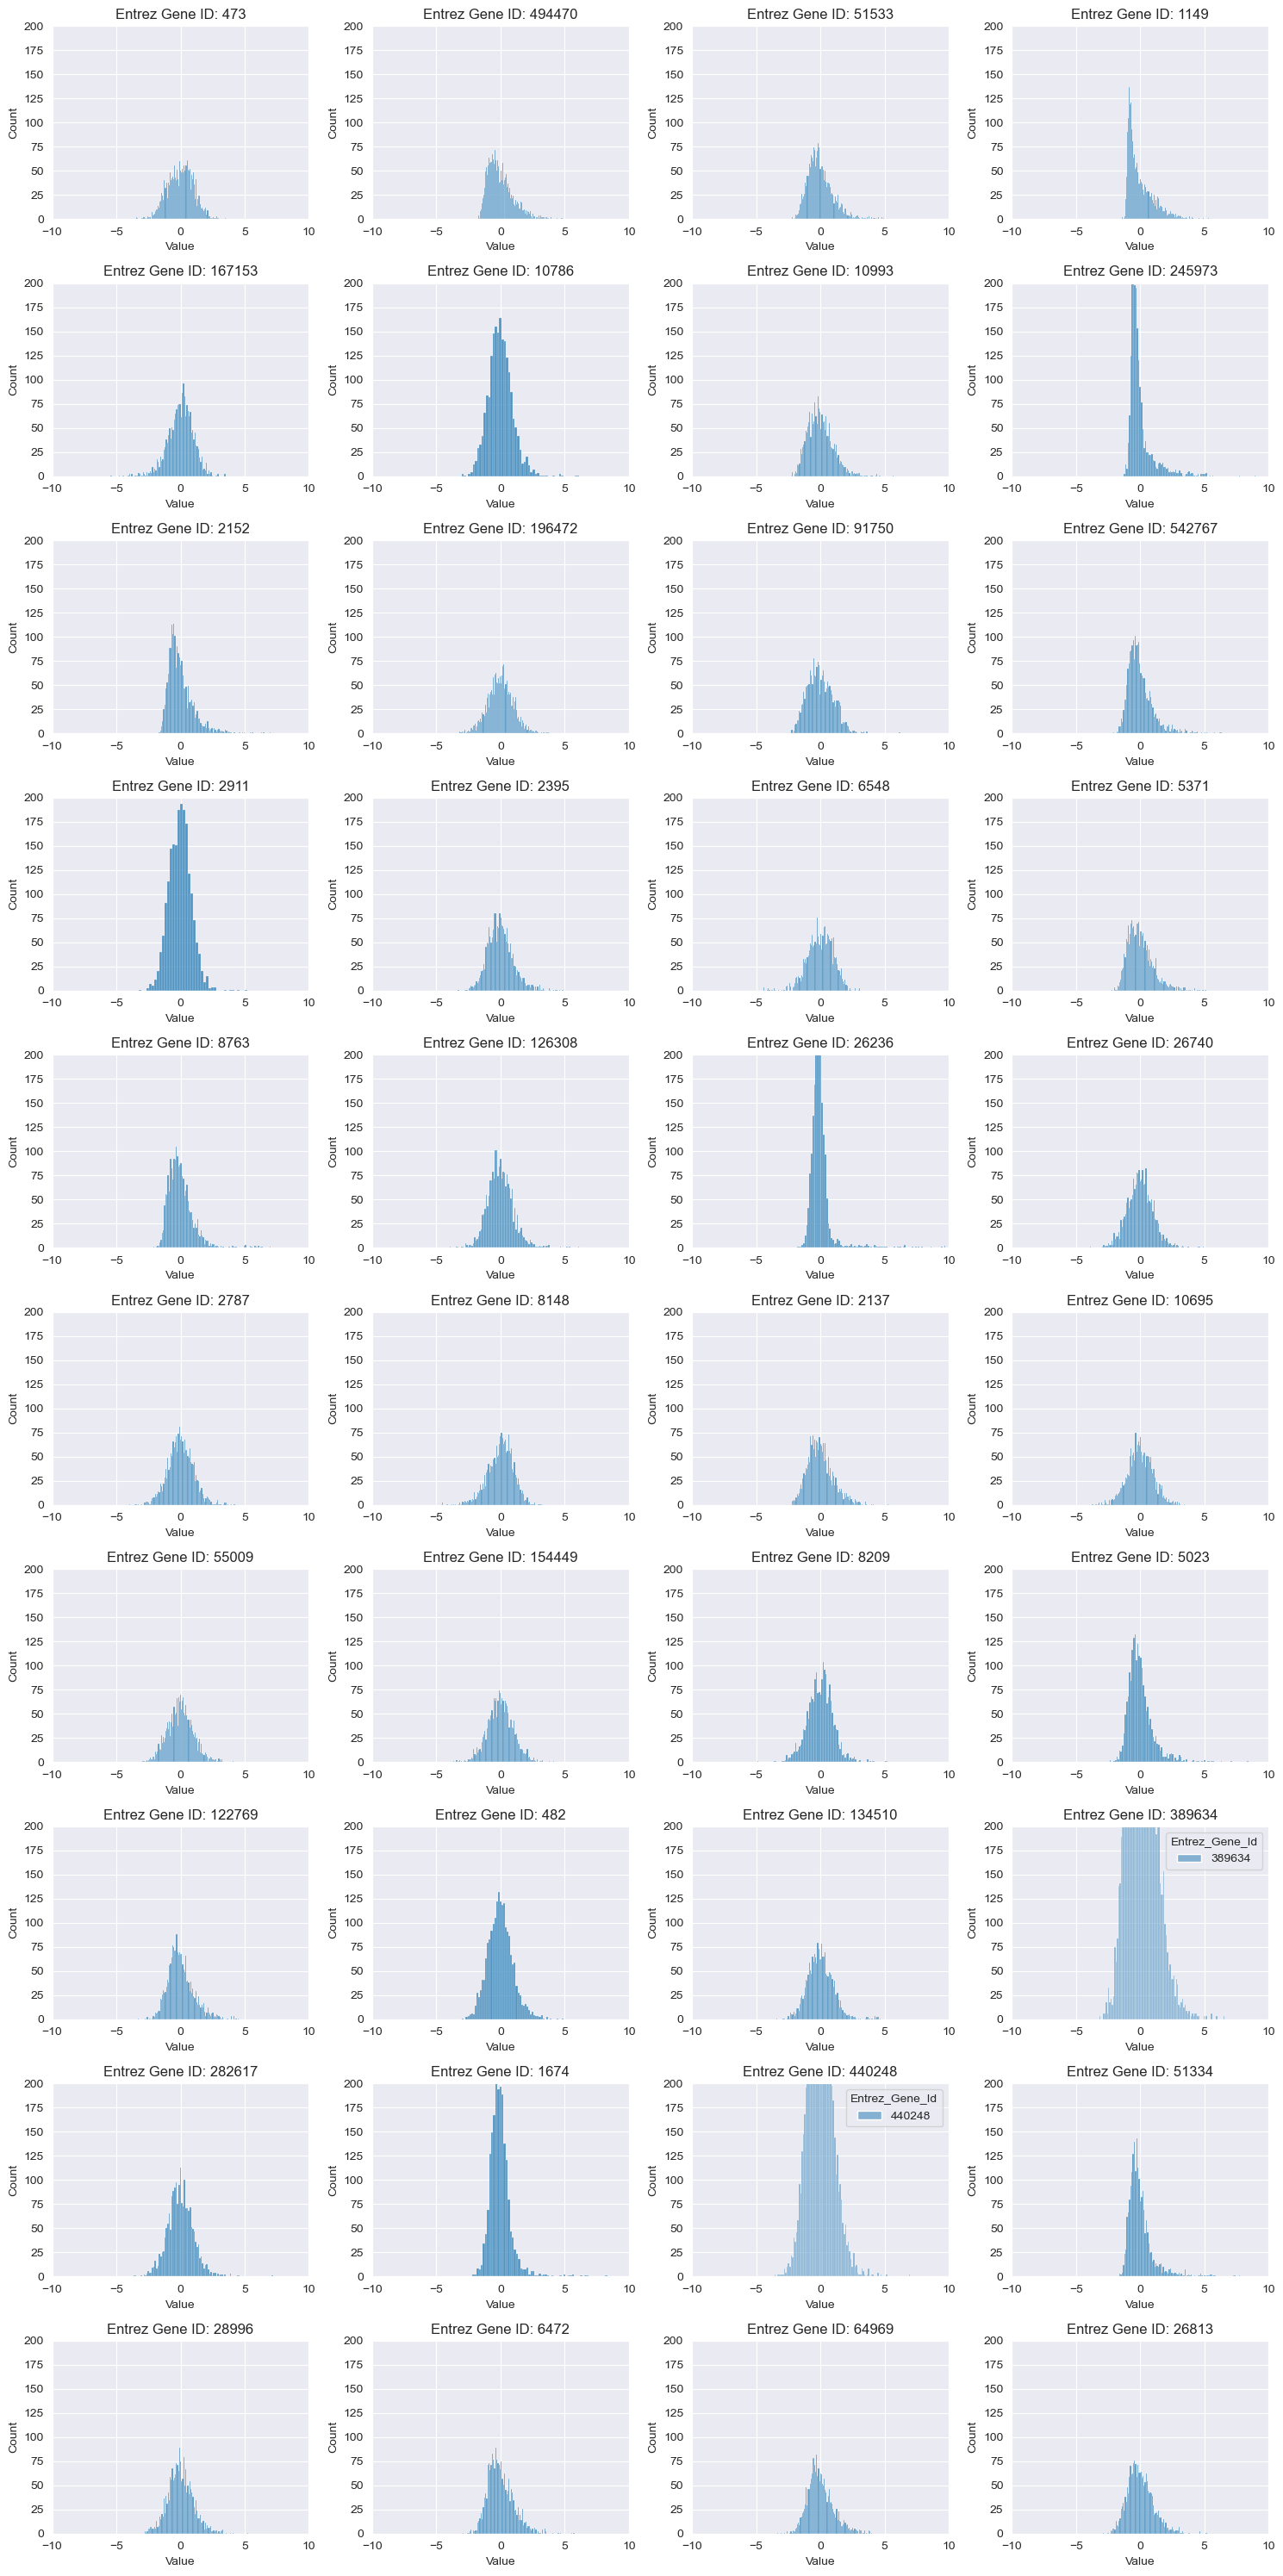

In [46]:
#| eval: false


#Shows Distribution of values of the first 40 Genes to check if Dataset is normalized

columns_to_plot = expr_transposed_df.columns[:40]
plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
  plt.subplot(10, 4, i + 1)
  sns.histplot(expr_transposed_df[column].dropna(), bins=100)
  plt.title(f'Entrez Gene ID: {column}')
  plt.xlabel("Value")
  plt.ylabel("Count")
  plt.xlim(-10, 10)
  plt.ylim(0, 200)
plt.tight_layout()
plt.savefig("../artifacts/images/Distribution_of_40_Genes.png", dpi=300)
plt.show()
plt.close()

##### Drop bad values in Expression Data

In [48]:
print(f'data shape before dropna: {expr_transposed_df.shape}')
expr_transposed_df = expr_transposed_df.dropna()
print(f"data shape after: {expr_transposed_df.shape}")

data shape before dropna: (1964, 20603)
data shape after: (1964, 20603)


##### Data Prints

In [ ]:
print(expr_transposed_df.describe())
print(expr_transposed_df.head())
print(meta_df.describe())

print(meta_df['CLAUDIN_SUBTYPE'].value_counts())

expr_transposed_df_long = expr_transposed_df.melt(var_name="Feature", value_name="Value")

## Data Plotting

Entrez_Gene_Id       473          494470       51533        1149    \
count           1964.000000  1964.000000  1964.000000  1964.000000   
mean              -0.003489    -0.003638    -0.002326    -0.003258   
std                1.000555     0.998993     1.000155     1.000001   
min               -3.448100    -1.724000    -2.189100    -1.415700   
25%               -0.729175    -0.754000    -0.688100    -0.753175   
50%                0.035200    -0.217950    -0.153400    -0.353350   
75%                0.691650     0.526725     0.527800     0.499025   
max                3.546700     4.863600     4.981200     5.367700   

Entrez_Gene_Id       167153       10786        10993        245973  \
count           1964.000000  1964.000000  1964.000000  1964.000000   
mean              -0.001214     0.001672     0.003771     0.000496   
std                1.001614     1.002272     0.998539     1.003114   
min               -5.437800    -3.024100    -2.205300    -1.291000   
25%               -

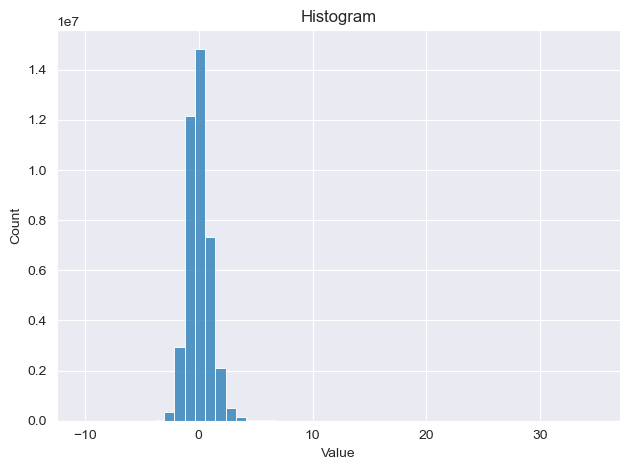

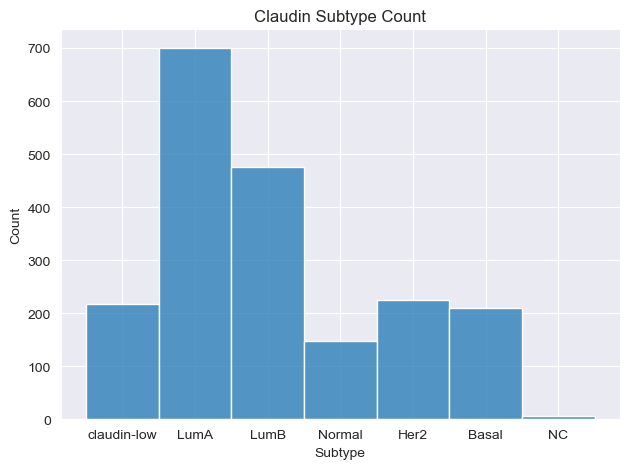

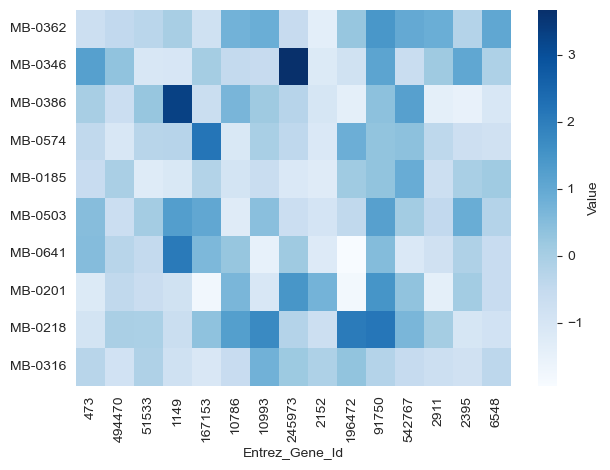

In [49]:
#Gene Plot
plt.figure()
sns.histplot(expr_transposed_df_long["Value"], bins=50)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.savefig("../artifacts/images/GenePlot.png")
plt.close()

#Claudin Subtype Plot
plt.figure()
sns.histplot(meta_df["CLAUDIN_SUBTYPE"], bins=7)
plt.title("Claudin Subtype Count")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.savefig("../artifacts/images/Claudin.png")
plt.close()

plt.figure()
sns.heatmap(expr_transposed_df.iloc[:10, :15], cmap="Blues", cbar_kws={'label': 'Value'})
plt.tight_layout()
plt.show()
plt.close()

## Plot PAM50 Genes

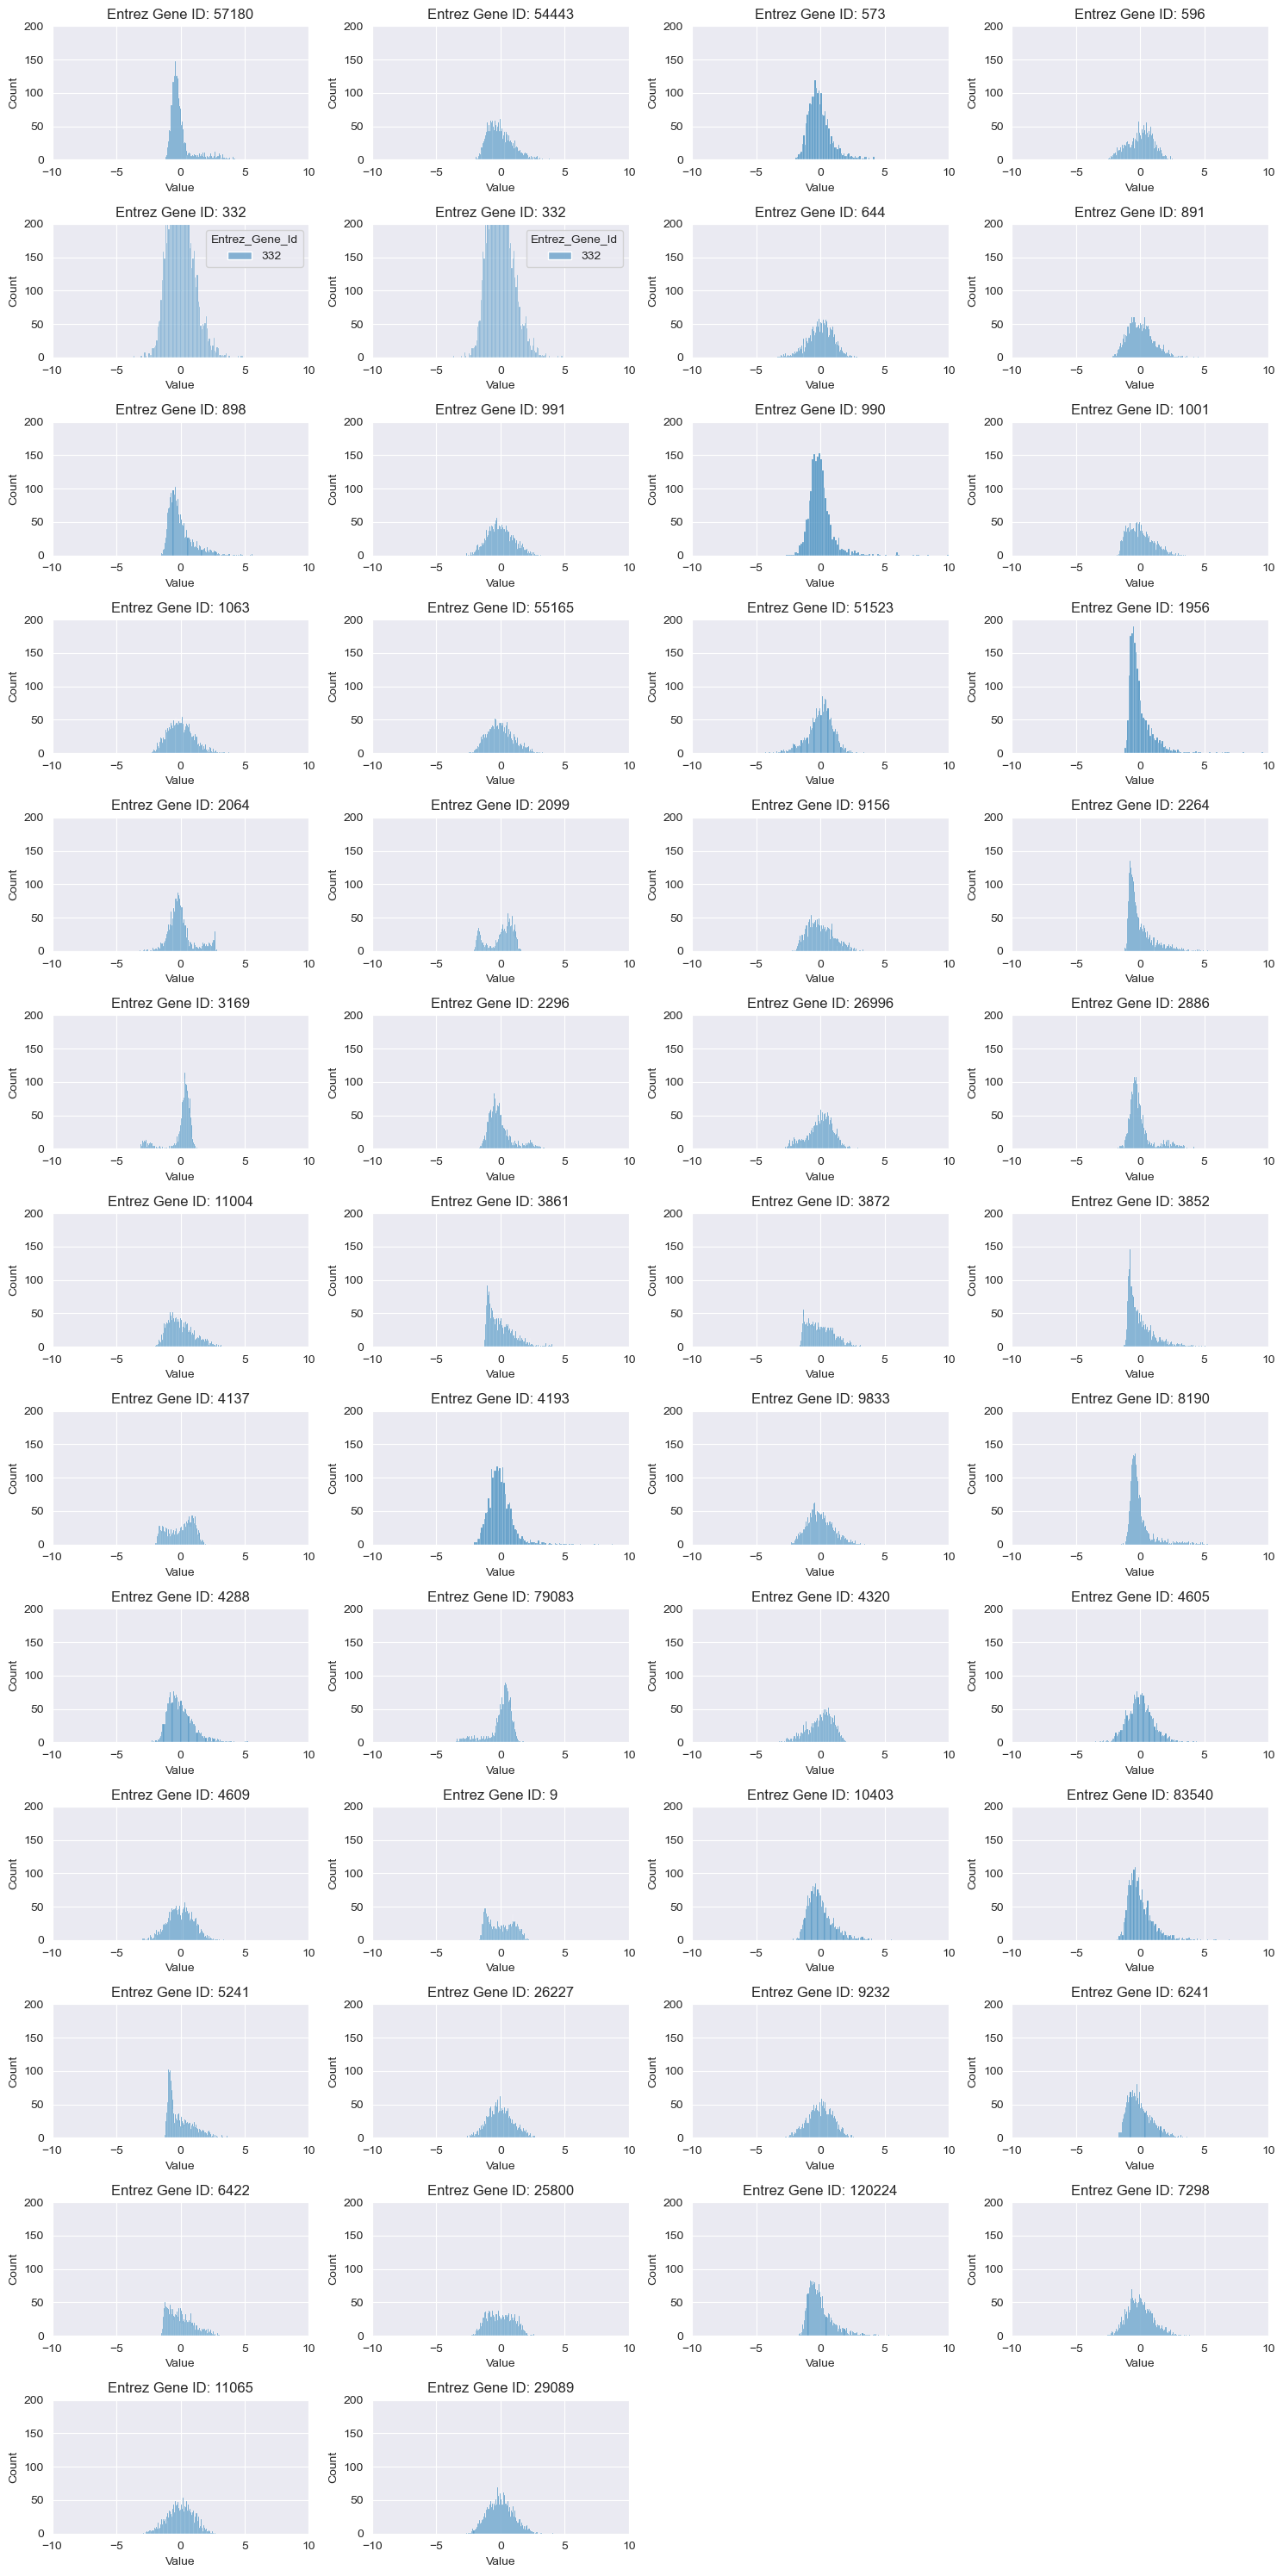

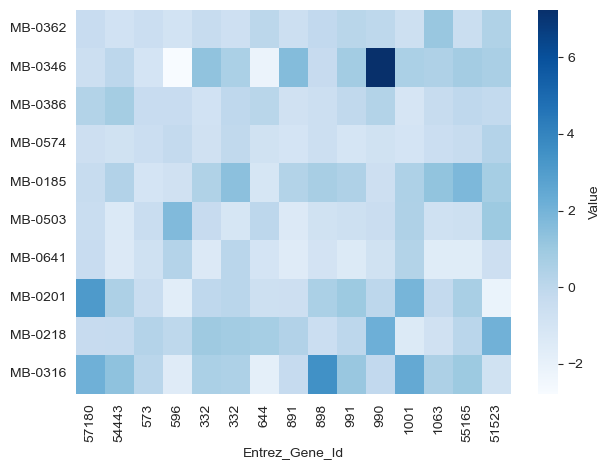

In [50]:
#| eval: false
PAM50_transposed_df

#Shows Distribution of values of PAM50_Genes

columns_to_plot = PAM50_transposed_df.columns[:50]
plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
  plt.subplot(13, 4, i + 1)
  sns.histplot(PAM50_transposed_df[column].dropna(), bins=100)
  plt.title("Distribution of PAM50 Values")
  plt.title(f'Entrez Gene ID: {column}')
  plt.xlabel("Value")
  plt.ylabel("Count")
  plt.xlim(-10, 10)
  plt.ylim(0, 200)
plt.tight_layout()
plt.savefig("../artifacts/images/Distribution_of_PAM50_Genes.png", dpi=300)
plt.show()
plt.close()

# Plot test Heatmap to compare to test Heatmap of Expression Set

plt.figure()
sns.heatmap(PAM50_transposed_df.iloc[:10, :15], cmap="Blues", cbar_kws={'label': 'Value'})
plt.tight_layout()
plt.show()

##### Drop columns in Meta - Concentration on ID and CLAUDIN

In [51]:
print(f'metadata shape before dropna: {meta_df.shape}')
print(f'Claudin Subtypes before dropna: {meta_df["CLAUDIN_SUBTYPE"].value_counts()}')

meta_reduced_df = meta_df.drop(columns=['LYMPH_NODES_EXAMINED_POSITIVE', "NPI", "CELLULARITY",
                                        "CHEMOTHERAPY", "COHORT", "ER_IHC", "HER2_SNP6", "HORMONE_THERAPY",
                                        "INFERRED_MENOPAUSAL_STATE"
  , "SEX", "INTCLUST", "AGE_AT_DIAGNOSIS", "OS_MONTHS", "OS_STATUS", "THREEGENE", "VITAL_STATUS", "LATERALITY",
                                        "RADIO_THERAPY", "HISTOLOGICAL_SUBTYPE", "BREAST_SURGERY", "RFS_MONTHS",
                                        "RFS_STATUS"])
# Dropnas of Meta here because we only need data of Claudine Typ, so we don't care if NA is in some other column
meta_reduced_df = meta_reduced_df.dropna()
print(f"metadata shape after: {meta_reduced_df.shape}")
print(meta_reduced_df.shape)
print(expr_transposed_df.shape)

metadata shape before dropna: (2509, 23)
Claudin Subtypes before dropna: CLAUDIN_SUBTYPE
LumA           700
LumB           475
Her2           224
claudin-low    218
Basal          209
Normal         148
NC               6
Name: count, dtype: int64
metadata shape after: (1980, 1)
(1980, 1)
(1964, 20603)


##### Merge Data with reduced Metadata on Patient-ID

In [90]:
# Change Claudine Subtypes from String to Integer
# LumA        --> 6   (its most often in the data so it gets the highest number)
# LumB        --> 5
# Her2        --> 4
# claudin-low --> 3
# Basal       --> 2
# Normal      --> 1
# NC          --> 0


#set Index Name of transposed expr_data the same as meta data
expr_transposed_df.index.name = 'PATIENT_ID'
#merge both sets together
merged_df = expr_transposed_df.merge(meta_reduced_df, how='left', on="PATIENT_ID")
#change Subtypes from String to numbers
merged_df["CLAUDIN_SUBTYPE"] = merged_df["CLAUDIN_SUBTYPE"].replace(
  {"LumA": "6", "LumB": "5", "Her2": "4", "claudin-low": "3", "Basal": "2", "Normal": "1",
   "NC": "0"})  # inplace = True
print(merged_df.shape)
print("Data Merged")

(1964, 20604)
Data Merged


##### Multivalorate Linear Regression

In [53]:
#Tensor Conversion

X = merged_df.iloc[:, 0:-1].values  #X = all expression data

Y = merged_df["CLAUDIN_SUBTYPE"].values  #Y = Claudin subtype
Y = Y.astype(int)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

print("Conversion to tensor done")

Conversion to tensor done


In [58]:
#Training

n_epochs = 124

model = nn.Linear(20603, 1)

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(n_epochs):
  y_pred = model(X)
  loss = loss_func(y_pred, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print("Fitted parameters:")
print("Intercept (bias):", model.bias.item())

## Notice more weights
print("Coefficients (weights):", model.weight.detach().numpy())
print('Loss: ', loss)

Fitted parameters:
Intercept (bias): 0.12286720424890518
Coefficients (weights): [[-0.00218855 -0.01279923  0.00196823 ...  0.00338346 -0.01069636
   0.01600808]]
Loss:  tensor(15.9659, grad_fn=<MseLossBackward0>)


## Model Evalution

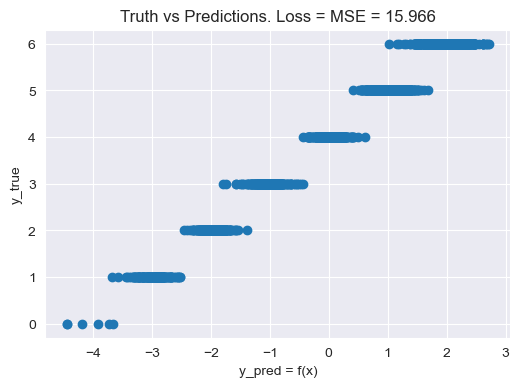

In [60]:
#Evaluation

model.eval()
y_pred = model(X)

# convert to numpy (only for plotting)
yp = y_pred.detach().numpy()
yt = Y.numpy()

title_str = f"Truth vs Predictions. Loss = MSE = {loss:.3f}"
plt.figure(figsize=(6, 4))
plt.plot(yp, yt, 'o')
plt.xlabel("y_pred = f(x)")
plt.ylabel("y_true")
plt.title(title_str)
plt.grid(True)
plt.show()
plt.close()

##### Multinomial Regression

In [61]:
#Tensor Conversion

X = merged_df.iloc[:-400, 0:-1].values  #X = all gene expression data

X_test = merged_df.iloc[-400:, 0:-1].values

Y = merged_df["CLAUDIN_SUBTYPE"].iloc[:-400].values  #Y = Claudin subtype
Y = Y.astype(int)

Y_test = merged_df["CLAUDIN_SUBTYPE"].iloc[-400:].values
Y_test = Y_test.astype(int)

X = torch.tensor(X, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

print("Conversion to tensor done")

Conversion to tensor done


In [62]:
#model training

n_epochs = 500
model = nn.Linear(20603, 7)  # change: n_in = 20603 (features), n_out = 7 (classes)
loss_func = nn.CrossEntropyLoss()  # Cross-Entropy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(n_epochs):
  # model predictions are interpreted as z = logits
  z = model(X)
  loss = loss_func(z, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print("Fitted parameters:")
print("Intercept (bias):", model.bias.detach().numpy())

## Notice more weights
print("Coefficients (weights):", model.weight.detach().numpy())
print('Loss: ', loss)

Fitted parameters:
Intercept (bias): [-0.00547005 -0.00340607 -0.01478642 -0.00729451 -0.01659031  0.01509504
  0.01004479]
Coefficients (weights): [[-0.00654469 -0.00477575  0.004834   ... -0.01226156 -0.00963251
  -0.02161265]
 [-0.00249552  0.00272055  0.00443179 ...  0.00467652 -0.01844149
   0.01669   ]
 [-0.00254477  0.0078012  -0.00447869 ...  0.00366892  0.00711197
  -0.00959448]
 ...
 [ 0.0039496  -0.00690494 -0.00812175 ... -0.00077007  0.00745548
  -0.01303869]
 [-0.0062447  -0.00876477  0.00238773 ... -0.01733709  0.01068021
  -0.02133751]
 [-0.00015606 -0.00899071  0.00566777 ...  0.01378229  0.00879122
   0.02645009]]
Loss:  tensor(7.6004e-05, grad_fn=<NllLossBackward0>)


In [63]:
#Model Evaluation
model.eval()
with torch.no_grad():
  z = model(X_test)
  y_prob = z.softmax(dim=1)  # for easier interpretation
  y_pred = z.argmax(dim=1)  # class predition = largest logit
  acc = (y_pred == Y_test).float().mean().item()

print('y_true:     ', Y[:7])
print('z (logits): ', z[:7])
print('y_prob:     ', y_prob[:7])
print('y_pred:     ', y_pred[:7])

print(f"\n\nTraining accuracy: {acc:.3f}")

y_true:      tensor([6, 4, 6, 6, 5, 6, 3])
z (logits):  tensor([[  2.9620,  -3.4558,   6.4380,  -3.6345,  16.2924,  -0.9714,  -5.7726],
        [ -7.3562,   0.2268,  -4.7522,  -8.1685,  -3.5604,   0.5927,  10.6707],
        [ 14.3140,  10.8089,  28.0032,  15.3582,  13.7340,  -7.9178, -29.0393],
        [ -4.1045,   6.3935,  -2.8904,  -3.4960, -11.5926, -11.4648,  16.4914],
        [ 17.9343,   0.6648,  25.4155,  32.4367,   6.5324,  -4.1103, -35.7958],
        [ -6.3953,  -3.2013,  -8.8896,  -8.1438,  -8.7606,   4.3081,  15.1101],
        [ 19.7280,  10.1076,  39.0167,  25.1138,  20.4421,  -8.9092, -45.7487]])
y_prob:      tensor([[1.6243e-06, 2.6511e-09, 5.2511e-05, 2.2174e-09, 9.9995e-01, 3.1798e-08,
         2.6137e-10],
        [1.4824e-08, 2.9123e-05, 2.0039e-07, 6.5793e-09, 6.5991e-07, 4.1991e-05,
         9.9993e-01],
        [1.1347e-06, 3.4090e-08, 9.9999e-01, 3.2236e-06, 6.3533e-07, 2.5103e-16,
         1.6857e-25],
        [1.1358e-09, 4.1162e-05, 3.8246e-09, 2.0871e-09, 6.35

## Multinomial Regression Confusion Matrix

<Figure size 1000x800 with 0 Axes>

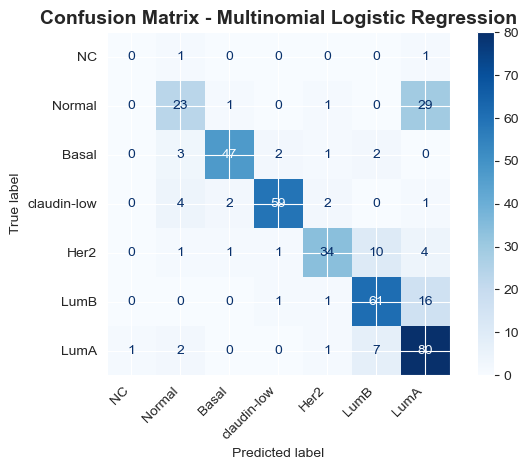


Classification Report:
              precision    recall  f1-score   support

          NC       0.00      0.00      0.00         2
      Normal       0.68      0.43      0.52        54
       Basal       0.92      0.85      0.89        55
 claudin-low       0.94      0.87      0.90        68
        Her2       0.85      0.67      0.75        51
        LumB       0.76      0.77      0.77        79
        LumA       0.61      0.88      0.72        91

    accuracy                           0.76       400
   macro avg       0.68      0.64      0.65       400
weighted avg       0.78      0.76      0.76       400



In [64]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Map numeric labels to actual class names
class_names = {0: "NC", 1: "Normal", 2: "Basal", 3: "claudin-low", 4: "Her2", 5: "LumB", 6: "LumA"}
labels = [0, 1, 2, 3, 4, 5, 6]
label_names = [class_names[i] for i in labels]

cm = confusion_matrix(Y_test, y_pred.numpy())

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Multinomial Logistic Regression', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

##### Classification report, Tensor conversion, model definition, model training

In [ ]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test.numpy(), y_pred.numpy(),
                            target_names=label_names,
                            labels=labels,
                            zero_division=0))

In [65]:
#Tensor Conversion

X = merged_df.iloc[:-400, 0:-1].values  #X = all gene expression data

X_test = merged_df.iloc[-400:, 0:-1].values

Y = merged_df["CLAUDIN_SUBTYPE"].iloc[:-400].values  #Y = Claudin subtype
Y = Y.astype(int)

Y_test = merged_df["CLAUDIN_SUBTYPE"].iloc[-400:].values
Y_test = Y_test.astype(int)

X = torch.tensor(X, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

print("Conversion to tensor done")

Conversion to tensor done


In [66]:
#Model Definition

class Classifier(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=512):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, 2048),
      nn.BatchNorm1d(2048),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(2048, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

    )

    self.latent = nn.Linear(512, hidden_dim)
    self.latent_bn = nn.BatchNorm1d(hidden_dim)
    self.classifier = nn.Linear(hidden_dim, output_dim)

  #    def forward(self, x):
  #        return self.net(x)

  def forward(self, x):
    # return NN(x) _and_ hidden_ state z_bn
    x = self.encoder(x)
    z = self.latent(x)
    z_bn = self.latent_bn(z)  # latent representation (approx. normal)
    out = self.classifier(z_bn)
    return out, z_bn  # return both for access later

#model = Classifier(input_dim, hidden_dim, output_dim)

In [88]:
#model training

n_epochs = 30
losslist = []
model = Classifier(input_dim=20603, output_dim=7)  # change: n_in = 20603 (features), n_out = 7 (classes)
loss_func = nn.CrossEntropyLoss()  # Cross-Entropy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(n_epochs):
  # model predictions are interpreted as z = logits
  z_out, z_bn = model(X)
  loss = loss_func(z_out, Y)
  losslist.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

##### Model Evalution

In [84]:
# Model Evalution
model.eval()
with torch.no_grad():
  z_out, z_bn = model(X_test)
  y_prob = z_out.softmax(dim=1)  # for easier interpretation
  y_pred = z_out.argmax(dim=1)  # class predition = largest logit
  acc = (y_pred == Y_test).float().mean().item()

print('y_true:     ', Y[:7])
#print('z (logits): ', z_out[:7])
print('y_prob:     ', y_prob[:7])
print('y_pred:     ', y_pred[:7])

print(f"\n\nTraining accuracy: {acc:.3f}")

y_true:      tensor([6, 4, 6, 6, 5, 6, 3])
y_prob:      tensor([[5.3986e-07, 1.7811e-07, 1.3497e-06, 1.3552e-08, 1.0000e+00, 3.3248e-07,
         4.4757e-08],
        [6.7218e-04, 2.5785e-04, 3.7380e-05, 3.9373e-05, 4.3887e-04, 8.9097e-05,
         9.9847e-01],
        [1.1048e-05, 3.5938e-04, 9.9953e-01, 1.6907e-05, 8.1718e-05, 8.6337e-08,
         1.2229e-08],
        [1.1297e-03, 4.7575e-03, 8.0451e-05, 6.5803e-05, 5.2259e-05, 5.7253e-06,
         9.9391e-01],
        [8.8503e-07, 6.0663e-07, 2.0983e-04, 9.9979e-01, 5.1444e-07, 8.5577e-07,
         2.2093e-09],
        [5.9075e-04, 1.2043e-04, 5.6135e-05, 1.2765e-04, 1.5782e-04, 2.1588e-04,
         9.9873e-01],
        [1.2265e-06, 1.9717e-06, 9.9990e-01, 9.0871e-05, 7.0853e-06, 1.0100e-08,
         5.1822e-11]])
y_pred:      tensor([4, 6, 2, 6, 3, 6, 2])


Training accuracy: 0.743


## Loss Plot and Confusion Matrix

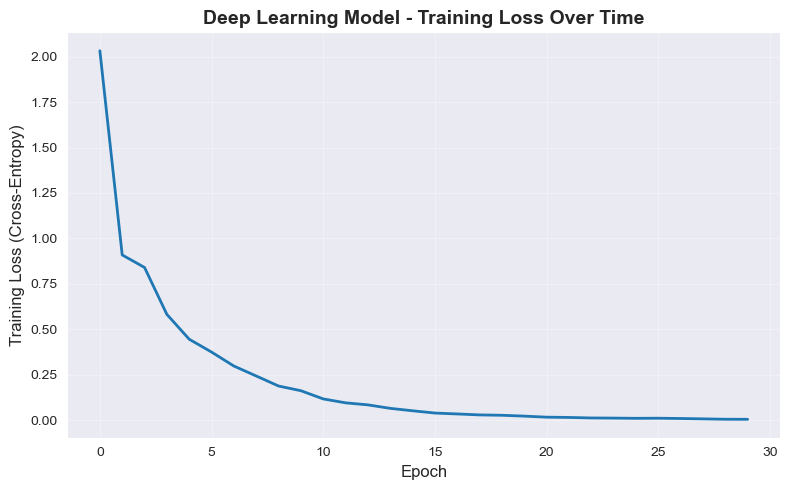

<Figure size 1000x800 with 0 Axes>

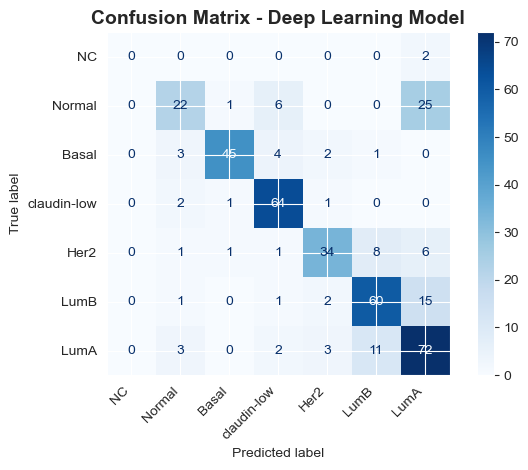

In [85]:
#loss plot

xs = [x for x in range(len(losslist))]
plt.figure(figsize=(8, 5))
plt.plot(xs, losslist, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (Cross-Entropy)', fontsize=12)
plt.title('Deep Learning Model - Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Map numeric labels to actual class names
class_names = {0: "NC", 1: "Normal", 2: "Basal", 3: "claudin-low", 4: "Her2", 5: "LumB", 6: "LumA"}
labels = sorted(torch.unique(Y_test).tolist())
label_names = [class_names[i] for i in labels]

cm = confusion_matrix(Y_test, y_pred.numpy())

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Deep Learning Model', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

#### detailed classification report

In [87]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test.numpy(), y_pred.numpy(),
                            target_names=label_names,
                            labels=labels,
                            zero_division=0))


Classification Report:
              precision    recall  f1-score   support

          NC       0.00      0.00      0.00         2
      Normal       0.69      0.41      0.51        54
       Basal       0.94      0.82      0.87        55
 claudin-low       0.82      0.94      0.88        68
        Her2       0.81      0.67      0.73        51
        LumB       0.75      0.76      0.75        79
        LumA       0.60      0.79      0.68        91

    accuracy                           0.74       400
   macro avg       0.66      0.63      0.63       400
weighted avg       0.75      0.74      0.74       400



##### Save Z_BN

In [69]:
model.eval()
with torch.no_grad():
  # right now its only saving the test zbn (data of 400 patients)
  _, z_bn_final = model(X_test)
  torch.save(z_bn_final.detach().cpu(), 'z_bn_final.pt')
  print(' Finales z_bn gespeichert → z_bn_final.pt')

 Finales z_bn gespeichert → z_bn_final.pt


##### Visualize Z Distribution

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to numpy for visualization
z_bn_np = z_bn_final.detach().cpu().numpy()

print(f"Z_BN Shape: {z_bn_np.shape}")
print(f"Z_BN Statistics:")
print(f"  Mean: {z_bn_np.mean():.4f}")
print(f"  Std: {z_bn_np.std():.4f}")
print(f"  Min: {z_bn_np.min():.4f}")
print(f"  Max: {z_bn_np.max():.4f}")

Z_BN Shape: (400, 512)
Z_BN Statistics:
  Mean: 0.0104
  Std: 1.1897
  Min: -7.9203
  Max: 8.0924


## 1. Distribution of Z values (Histogram)

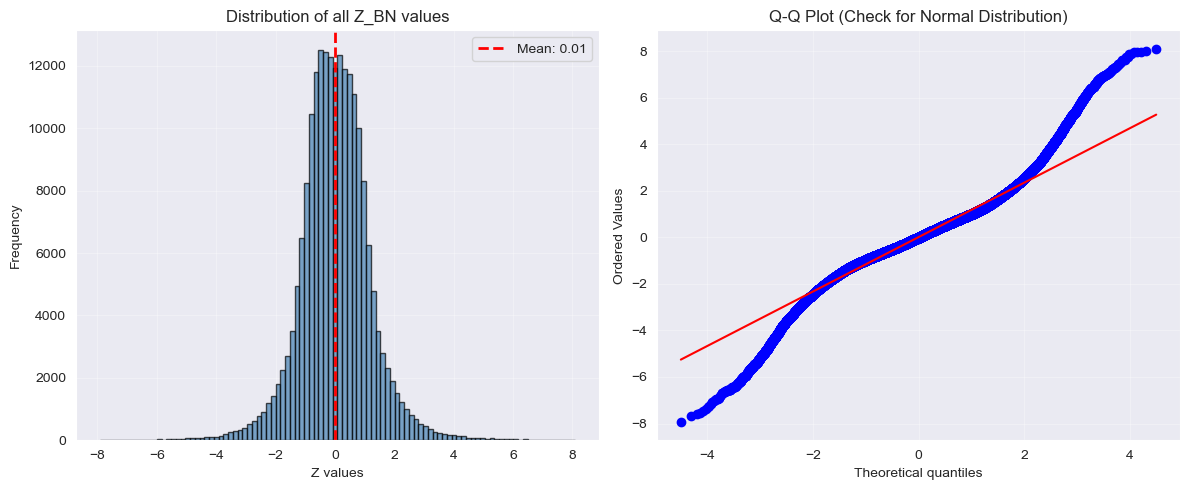

In [71]:
# Plot histogram of all Z values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(z_bn_np.flatten(), bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(z_bn_np.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {z_bn_np.mean():.2f}')
plt.xlabel('Z values')
plt.ylabel('Frequency')
plt.title('Distribution of all Z_BN values')
plt.legend()
plt.grid(True, alpha=0.3)

# Q-Q plot to check normality
plt.subplot(1, 2, 2)
from scipy import stats

sample_values = z_bn_np.flatten()
stats.probplot(sample_values, dist="norm", plot=plt)
plt.title('Q-Q Plot (Check for Normal Distribution)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Distribution per Dimension

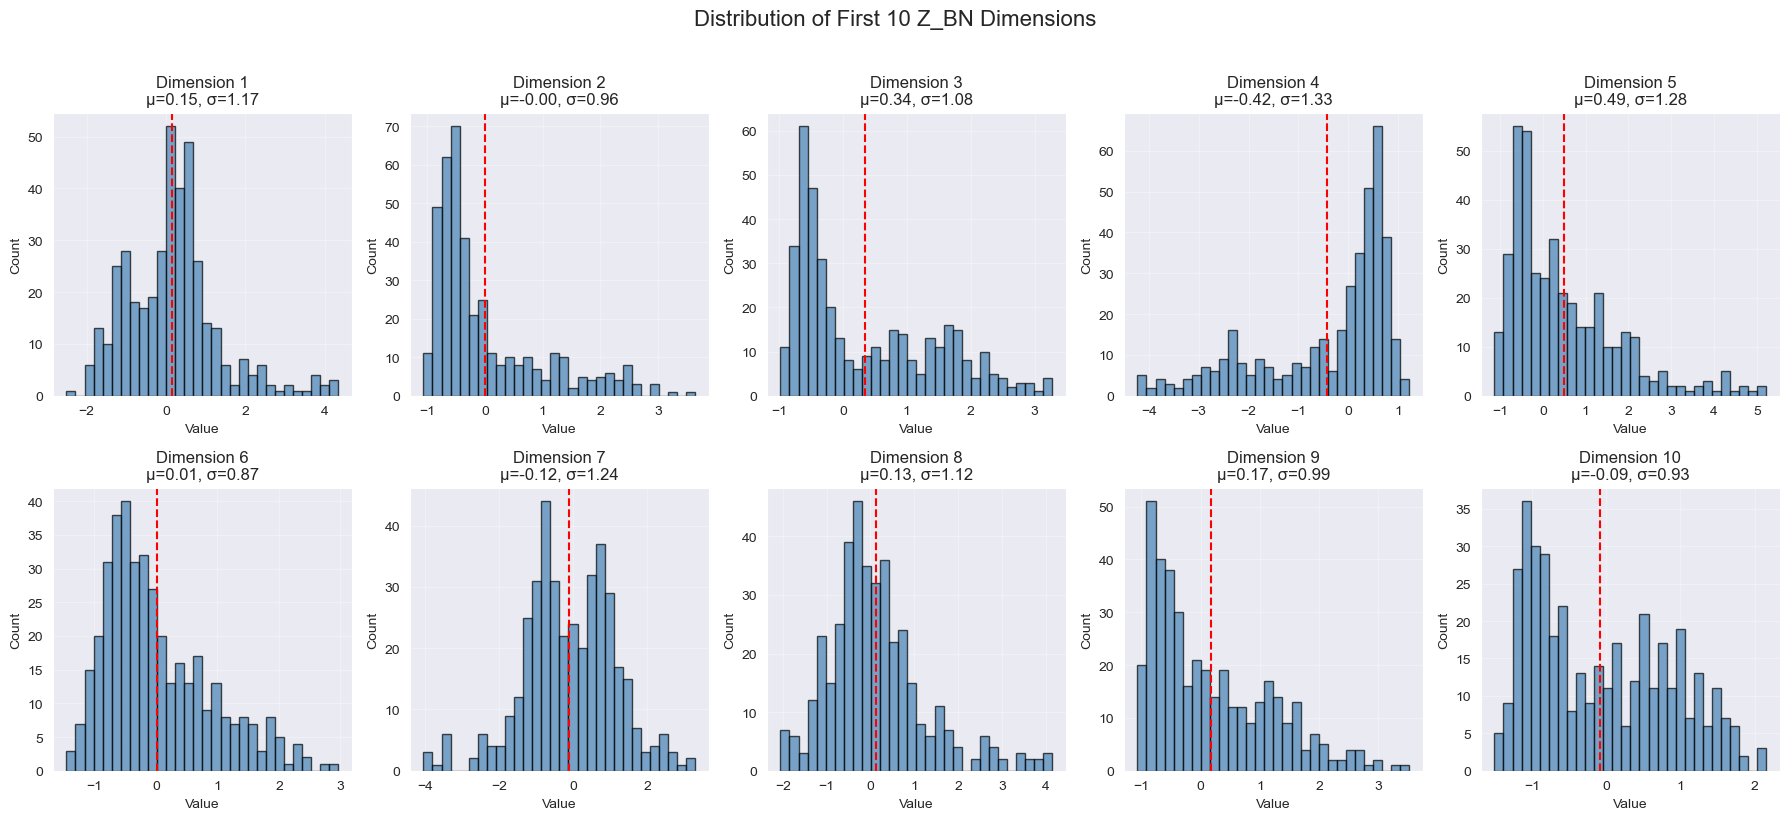

In [72]:
# Show distribution statistics for first 10 dimensions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i in range(min(10, z_bn_np.shape[1])):
  axes[i].hist(z_bn_np[:, i], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
  axes[i].axvline(z_bn_np[:, i].mean(), color='red', linestyle='--', linewidth=1.5)
  axes[i].set_title(f'Dimension {i + 1}\nμ={z_bn_np[:, i].mean():.2f}, σ={z_bn_np[:, i].std():.2f}')
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Count')
  axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribution of First 10 Z_BN Dimensions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 3. Correlation Matrix of Z dimensions

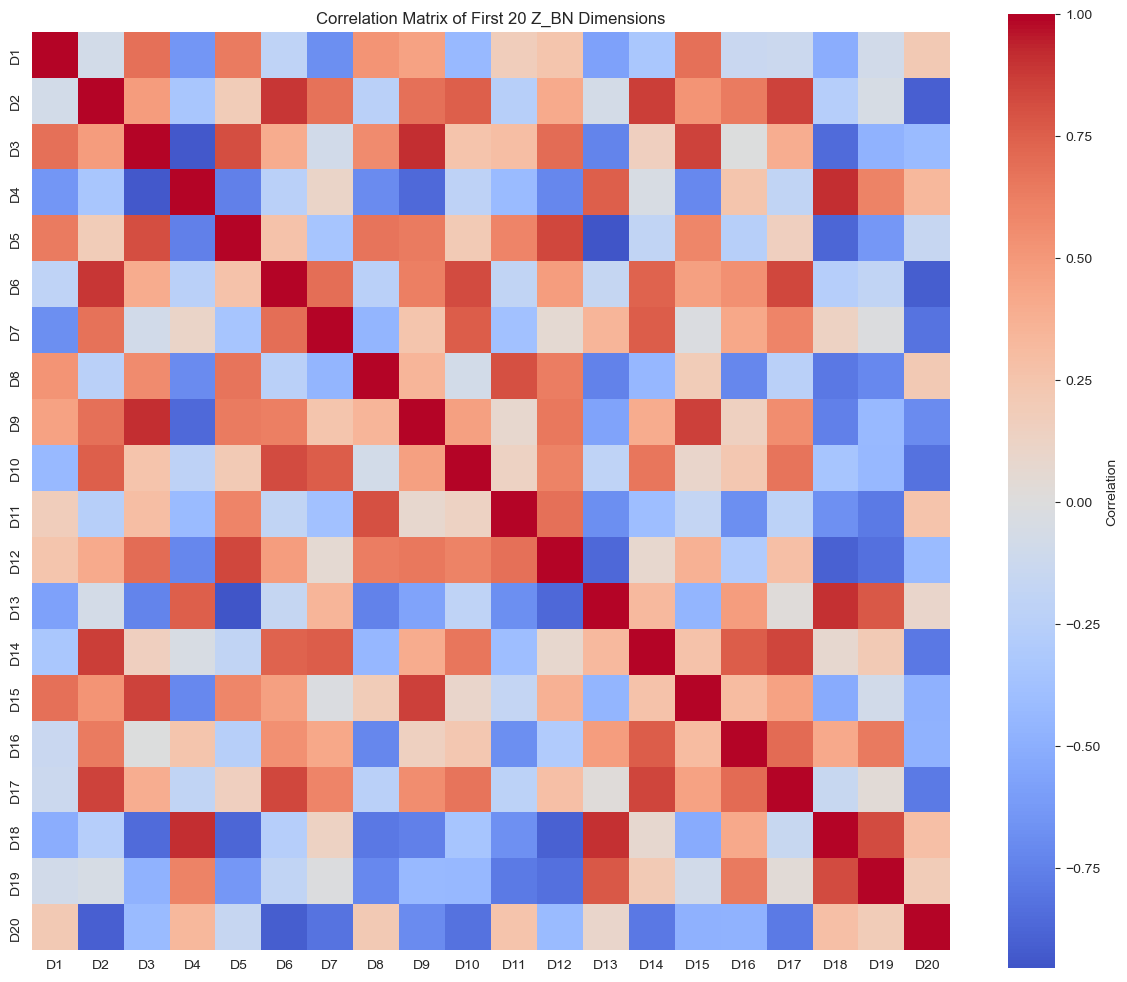


Mean absolute correlation (off-diagonal): 0.4704


In [73]:
# Show correlation between Z dimensions (sample subset)
n_dims_corr = min(20, z_bn_np.shape[1])
correlation_matrix = np.corrcoef(z_bn_np[:, :n_dims_corr].T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            cmap='coolwarm', center=0,
            square=True,
            xticklabels=[f'D{i + 1}' for i in range(n_dims_corr)],
            yticklabels=[f'D{i + 1}' for i in range(n_dims_corr)],
            cbar_kws={'label': 'Correlation'})
plt.title(f'Correlation Matrix of First {n_dims_corr} Z_BN Dimensions')
plt.tight_layout()
plt.show()

print(
  f"\nMean absolute correlation (off-diagonal): {np.abs(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]).mean():.4f}")

##### Model Save

In [74]:
#Saving the model at artifacts
path = '../artifacts/model.pt'

torch.save(model, path)
print(f"Model saved at {path}")

Model saved at ../artifacts/model.pt


### Divide into Full dim and PCA representation


### Switching between settings of meta data

In [79]:
from sklearn.model_selection import train_test_split


#Takes a metadata column name (like "THREEGENE" or "CLAUDIN_SUBTYPE").

#Cleans it (drops NA, removes invalid categories like "NC" or 0).

#Merges it with expression data.

#Splits it automatically into training and test sets (80/20).

def show_metadata_column(meta_df, column_name):
  if column_name in meta_df.columns:

    #remove empty values
    meta_clean = meta_df[[column_name]].dropna()

    #remove invalid values 'NC' and '0'
    meta_clean = meta_clean[~meta_clean[column_name].isin(["NC", "0"])]

    #Merge with expression data
    merged_df = expr_transposed_df.merge(meta_clean, left_index=True, right_index=True)

    #Training and test sets (80/20)
    X = merged_df.iloc[:, :-1]
    Y = merged_df.iloc[:, -1]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

    #sample count
    n_total = len(X)

    #print
    print(f"Metadata column '{column_name}' cleaned and merged with expression data")
    print(f"Total samples: {n_total}")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_test, Y_train, Y_test

  else:
    print(f"Column '{column_name}' does not exist in meta_df")

## PCA representation

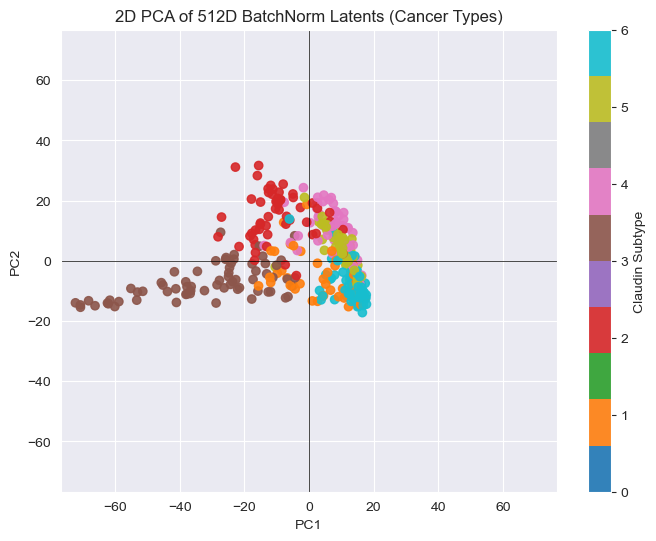

In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#z_bn (batch normalization)
z_bn_np = z_bn.detach().numpy()

#Y_test = tensor with labels
labels = Y_test.numpy()

#reduce PCA data to 2D
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_bn_np)

#center PCA
z_2d_centered = z_2d - z_2d.mean(axis=0)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
  z_2d_centered[:, 0],
  z_2d_centered[:, 1],
  c=labels,
  cmap='tab10',
  alpha=0.9
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of 512D BatchNorm Latents (Cancer Types)")
plt.colorbar(scatter, label="Claudin Subtype")

# symmetrical axis
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

lim = max(abs(xmin), abs(xmax), abs(ymin), abs(ymax))

plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.show()